# 17-6. 프로젝트 - Movielens 영화 SBR

Movielens 1M Dataset을 기반으로, Session based Recommendation 시스템을 제작해 보겠습니다.

데이터는 아래와 같이 정리합니다. 


``` python 
# 1) wget으로 데이터 다운로드
$ wget http://files.grouplens.org/datasets/movielens/ml-1m.zip

# 2) 다운받은 데이터를 작업디렉토리로 이동
$ mv ml-1m.zip ~/aiffel/yoochoose-data

# 3) 압축 해제
$ cd ~/aiffel/yoochoose-data && unzip ml-1m.zip
```

In [21]:
import datetime as dt
from pathlib import Path
import os
import matplotlib as plt
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [192]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, GRU
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm

In [114]:
pd.set_option('display.max_row', 500)

In [130]:
data_path = Path(os.getenv('HOME')+'/aiffel/yoochoose-data/ml-1m') 
train_path = data_path / 'ratings.dat'

def load_data(data_path: Path, nrows=None):
    data = pd.read_csv(data_path, sep='::', header=None, usecols=[0, 1, 2, 3], dtype={0: np.int32, 1: np.int32, 2: np.int32}, nrows=nrows)
    data.columns = ['UserId', 'ItemId', 'Rating', 'Time']
    return data

data = load_data(train_path, None)
data.sort_values(['UserId', 'Time'], inplace=True)  # data를 id와 시간 순서로 정렬해줍니다.
data


,UserId,ItemId,Rating,Time
31,1,3186,4,978300019
22,1,1270,5,978300055
27,1,1721,4,978300055
37,1,1022,5,978300055
24,1,2340,3,978300103
...,...,...,...,...
1000019,6040,2917,4,997454429
999988,6040,1921,4,997454464
1000172,6040,1784,3,997454464
1000167,6040,161,3,997454486


In [131]:
data.Time = pd.to_datetime(data.Time, dayfirst = "1970-01-01", unit = 's')

In [132]:
data.Time

31        2000-12-31 22:00:19
22        2000-12-31 22:00:55
27        2000-12-31 22:00:55
37        2000-12-31 22:00:55
24        2000-12-31 22:01:43
                  ...        
1000019   2001-08-10 14:40:29
999988    2001-08-10 14:41:04
1000172   2001-08-10 14:41:04
1000167   2001-08-10 14:41:26
1000042   2001-08-20 13:44:15
Name: Time, Length: 1000209, dtype: datetime64[ns]

## Step 1. 데이터 EDA, 전처리 
위와 같이 간단히 구성해 본 데이터셋을 꼼꼼이 살펴보면서 항목별 기본분석, session length, session time, cleaning 등의 작업을 진행합니다.
특히, 이 데이터셋에서는 Session이 아닌 UserID 단위로 데이터가 생성되어 있으므로, 이를 Session 단위로 어떻게 해석할지에 주의합니다.

In [133]:
data['UserId'].nunique(), data['ItemId'].nunique()

(6040, 3706)

총 6040명의 유저들이 3706개의 영화를 평가한것을 확인할 수 있습니다.                 


In [134]:
data.groupby('UserId').size()

UserId
1        53
2       129
3        51
4        21
5       198
       ... 
6036    888
6037    202
6038     20
6039    123
6040    341
Length: 6040, dtype: int64

유저별로 얼마나 활동했는지 정리해보도록 하겠습니다.

In [136]:
data.groupby('UserId').size().mean() , data.groupby('UserId').size().median()

(165.5975165562914, 96.0)

유저별로 평균 165개의 영화를 보았습니다. 중앙값은 96입니다. 아무래도 HEAVY 유저들때문에 평균값이 더 치우진 결과를 만든 것 같네요

In [137]:
data.groupby('UserId').size().min(), data.groupby('UserId').size().max()

(20, 2314)

가장 적은 영화를 본 유저는 20편, 가장 많은 영화를 본사람은 2314편이나 봤습니다.

In [138]:
data.groupby('UserId').size().quantile(0.90)

400.0

상위 10%의 영화를 본사람들이 400편 정도를 봤네요. 

<AxesSubplot:>

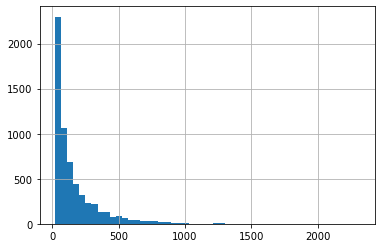

In [140]:
data.groupby('UserId').size().hist(bins = 50)

히스토그램으로 보면 아래와 같습니다.
좀 더 자세히 보기위해 matplotlib의 hist를 사용하겠습니다.

(array([2.298e+03, 1.063e+03, 6.880e+02, 4.420e+02, 3.240e+02, 2.330e+02,
        2.170e+02, 1.290e+02, 1.320e+02, 8.000e+01, 8.400e+01, 6.500e+01,
        4.400e+01, 3.700e+01, 3.400e+01, 3.200e+01, 2.600e+01, 2.300e+01,
        2.300e+01, 1.200e+01, 1.100e+01, 1.100e+01, 3.000e+00, 2.000e+00,
        3.000e+00, 3.000e+00, 8.000e+00, 5.000e+00, 2.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 2.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00]),
 array([  20.  ,   65.88,  111.76,  157.64,  203.52,  249.4 ,  295.28,
         341.16,  387.04,  432.92,  478.8 ,  524.68,  570.56,  616.44,
         662.32,  708.2 ,  754.08,  799.96,  845.84,  891.72,  937.6 ,
         983.48, 1029.36, 1075.24, 1121.12, 1167.  , 1212.88, 1258.76,
        1304.64, 1350.52, 1396.4 , 1442.28, 1488.16, 1534.04, 1579.92,
        1625.8 , 1671

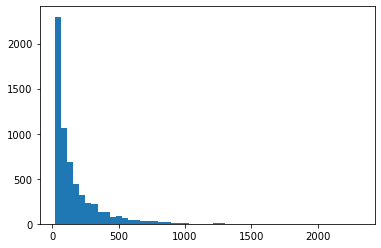

In [141]:
plt.pyplot.hist(data.groupby('UserId').size().values.tolist(), bins = 50)

2.298e+03 + 1.063e+03 = 3361, 3361명의 사람이 111번만큼의 영화를 봤습니다.              
즉 절반 넘는 숫자가 111번 보다 미만으로 봤다고 볼 수 있습니다. 

<AxesSubplot:>

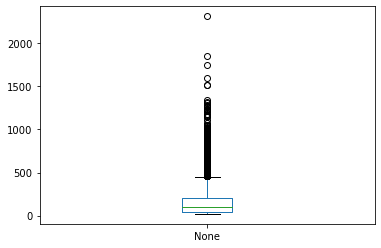

In [142]:
data.groupby('UserId').size().plot.box()

AxesSubplot(0.125,0.125;0.775x0.755)


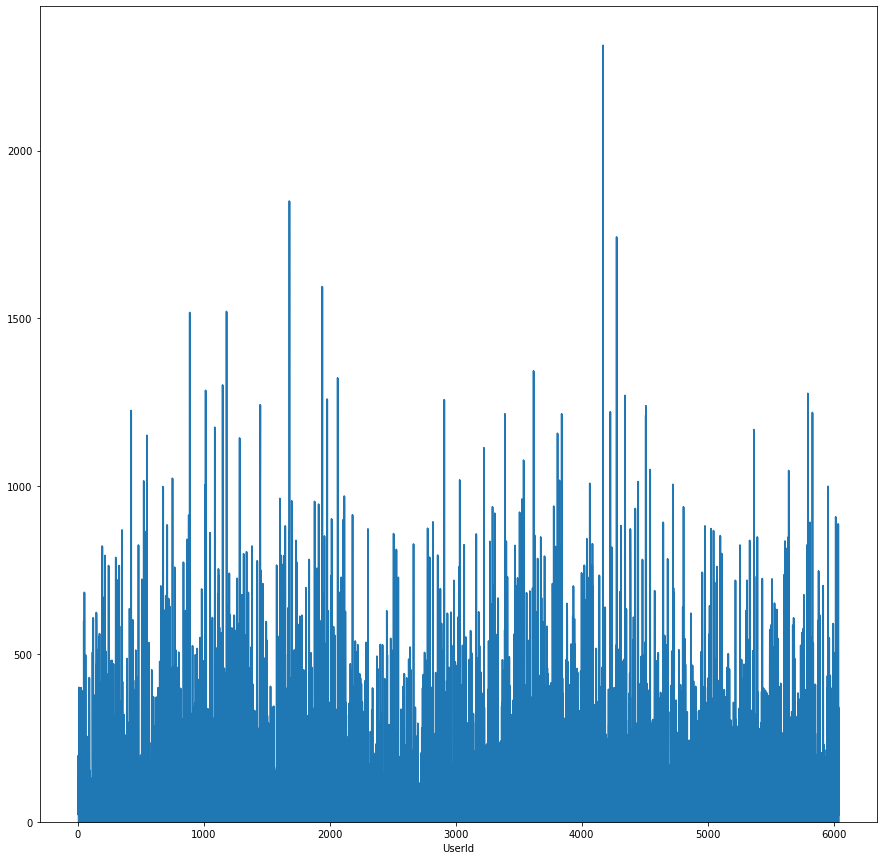

In [143]:
print(data.groupby('UserId').size().plot.area(figsize = (15,15)))

id에 따라서는 이렇게 되군요. 한번 2000편 이상, 정확히 2314번 본 유저에 대해서 살펴보도록 하겠습니다.

In [144]:
movie_2314 = data.groupby('UserId').size()[data.groupby('UserId').size() == 2314].index[0]

In [145]:
movie_2314

4169

In [146]:
movie_2314 = data[data['UserId'] == 4169]

In [157]:
movie_2314.head(100)

,UserId,ItemId,Rating,Time
696969,4169,1268,5,2000-08-03 20:09:52
697168,4169,2617,4,2000-08-03 20:09:52
697185,4169,2628,4,2000-08-03 20:09:52
697219,4169,2653,4,2000-08-03 20:09:52
697275,4169,423,3,2000-08-03 20:09:52
696168,4169,3801,5,2000-08-03 20:11:21
696250,4169,3841,2,2000-08-03 20:11:21
697903,4169,3761,3,2000-08-03 20:11:21
697954,4169,3788,3,2000-08-03 20:11:21
695653,4169,3794,4,2000-08-03 20:11:59


In [156]:
movie_2314.tail(100)

,UserId,ItemId,Rating,Time
696438,4169,3145,4,2001-03-29 01:06:05
697753,4169,2763,4,2001-03-29 01:08:40
696069,4169,252,4,2001-03-29 01:08:58
697096,4169,2280,3,2001-03-29 01:10:22
696377,4169,2166,4,2001-03-29 01:11:18
697415,4169,1367,4,2001-03-29 01:14:40
697444,4169,2327,3,2001-03-29 01:18:20
696790,4169,3598,3,2001-04-26 22:04:20
696225,4169,2889,4,2001-04-26 22:23:41
696616,4169,2590,2,2001-04-26 22:24:42


대다수 유저들은 적은수의 평가를 했으며 500편 이상의 영화를 본 유저들은 극히 드물다는것을 확인했습니다.

In [176]:
length_per_user = data.groupby('UserId').size()
length_per_user 

UserId
1        53
2       129
3        51
4        21
5       198
       ... 
6036    888
6037    202
6038     20
6039    123
6040    341
Length: 6040, dtype: int64

In [186]:
length_count = length_per_user.groupby(length_per_user).size() #value값을 가지는 cout를 나타낸다. 

In [187]:
length_count

20      86
21      91
22      77
23      81
24      81
        ..
1521     1
1595     1
1743     1
1850     1
2314     1
Length: 743, dtype: int64

In [189]:
length_percent_cumsum =  length_count.cumsum() / length_count.sum()
length_percent_cumsum_999 = length_percent_cumsum[length_percent_cumsum < 0.999]

In [190]:
length_percent_cumsum_999

20      0.014238
21      0.029305
22      0.042053
23      0.055464
24      0.068874
          ...   
1271    0.998179
1277    0.998344
1286    0.998510
1302    0.998675
1323    0.998841
Length: 736, dtype: float64

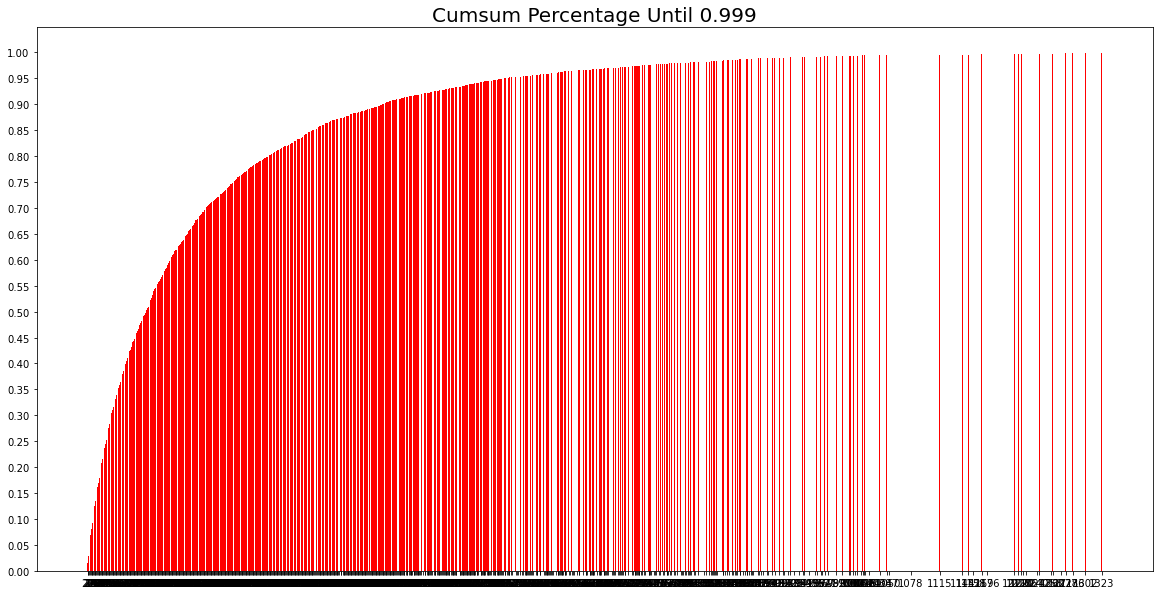

In [191]:
import matplotlib.pyplot as plt
plt.figure(figsize = (20, 10))
plt.bar(x=length_percent_cumsum_999.index,
        height=length_percent_cumsum_999, color='red')
plt.xticks(length_percent_cumsum_999.index)
plt.yticks(np.arange(0, 1.01, 0.05))
plt.title('Cumsum Percentage Until 0.999', size=20)
plt.show()

이 유저들을 세션단위로 예측하려면 시간순으로 정리하는 것이 적당하다고 생각합니다.

In [148]:
data.sort_values(['UserId','Time'])

,UserId,ItemId,Rating,Time
31,1,3186,4,2000-12-31 22:00:19
22,1,1270,5,2000-12-31 22:00:55
27,1,1721,4,2000-12-31 22:00:55
37,1,1022,5,2000-12-31 22:00:55
24,1,2340,3,2000-12-31 22:01:43
...,...,...,...,...
1000019,6040,2917,4,2001-08-10 14:40:29
999988,6040,1921,4,2001-08-10 14:41:04
1000172,6040,1784,3,2001-08-10 14:41:04
1000167,6040,161,3,2001-08-10 14:41:26


## Step 2. 미니 배치의 구성
실습코드 내역을 참고하여 데이터셋과 미니 배치를 구성해 봅시다. Session-Parallel Mini-Batch의 개념에 따라, 학습 속도의 저하가 최소화될 수 있도록 구성합니다.
단, 위 Step 1에서 Session 단위를 어떻게 정의했느냐에 따라서 Session-Parallel Mini-Batch이 굳이 필요하지 않을 수도 있습니다.

## Step 3. 모델 구성
이 부분도 실습코드 내역을 참고하여 다양하게 모델 구조를 시도해볼 수 있습니다.

## Step 4. 모델 학습
다양한 하이퍼파라미터를 변경해 보며 검증해 보도록 합니다. 실습코드에 언급되었던 Recall, MRR 등의 개념들도 함께 관리될 수 있도록 합니다.

## Step 5. 모델 테스트
미리 구성한 테스트셋을 바탕으로 Recall, MRR 을 확인해 봅니다.

In [158]:
# p = data.set_index(['Time','UserId']).groupby(level=[0,1]) p.head()

# 소고 데이터셋이 달라서 고민이 많았다ㅡ
분석어렵다.

pandas 책사서 공부좀 더 해야겠다.

